# Part 1: Multilinear & Polynomial Regression
## Objective:
* Preprocess data.
* Apply Multilinear and Polynomial Regression models.
* Compare performance using RMSE and R² scores.

**Importing the Libraries**

In [ ]:
# Importing libraries for data manipulation, numerical operations, plotting, and ML.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Enabling Google Drive access for Kaggle downloaded file.
from google.colab import drive

# Importing Scikit-learn modules for model building and evaluation.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Setting up a random seed to ensure consistant data splits and results across multiple runs.
np.random.seed(42)

# Setting up for consistent style of plots
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully.")

Libraries imported successfully.


**Data Preprocessing**

Mounted at /content/drive
Google Drive mounted successfully.

Attempting to load dataset from Google Drive: /content/drive/MyDrive/StudentsPerformance.csv
Dataset loaded successfully from Google Drive.

Dataset columns renamed for consistency:
Index(['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch',
       'test_preparation_course', 'math_score', 'reading_score',
       'writing_score'],
      dtype='object')

First 5 rows of the dataset:
   gender race_ethnicity parental_level_of_education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test_preparation_course  math_score  reading_score  writing_score  
0                    none          72           

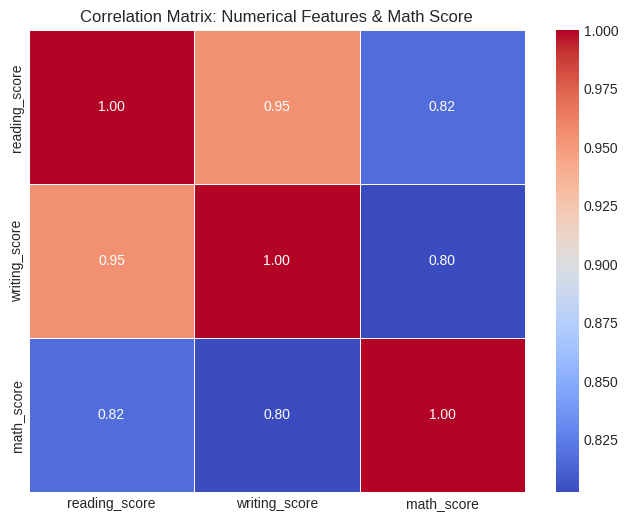


Correlation of numerical features with 'math_score':
reading_score    0.817580
writing_score    0.802642
Name: math_score, dtype: float64

Visualizing relationship between categorical features and 'math_score'...


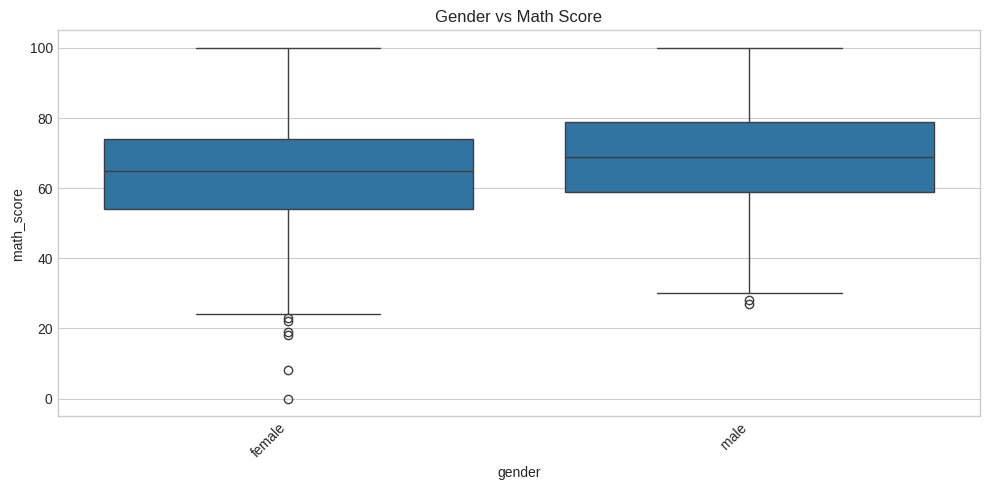

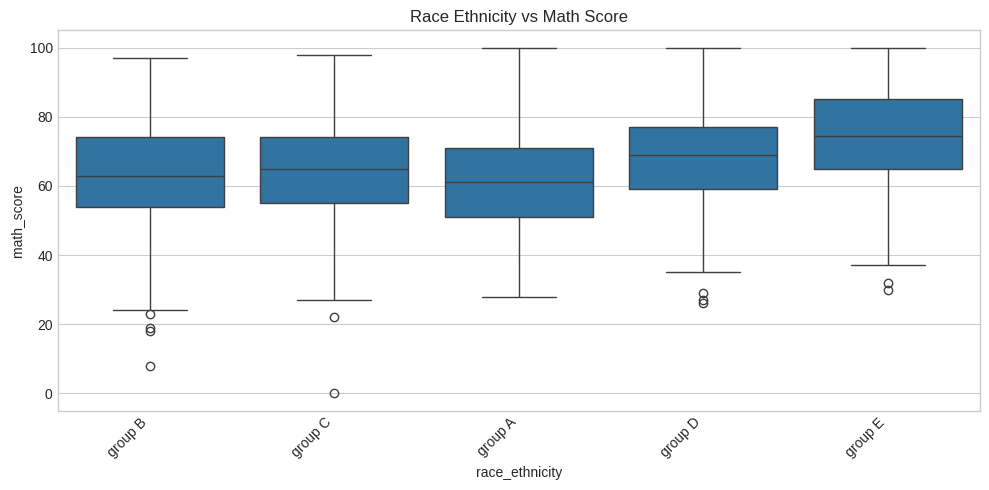

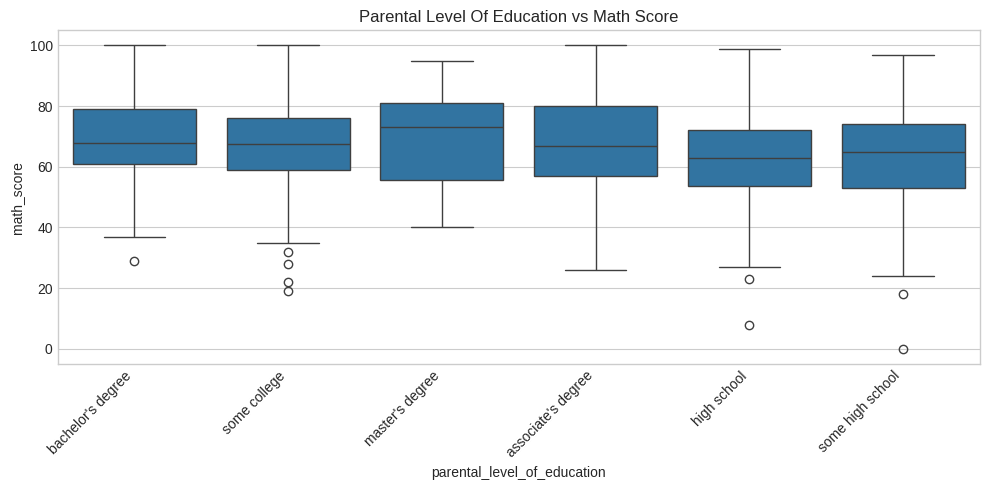

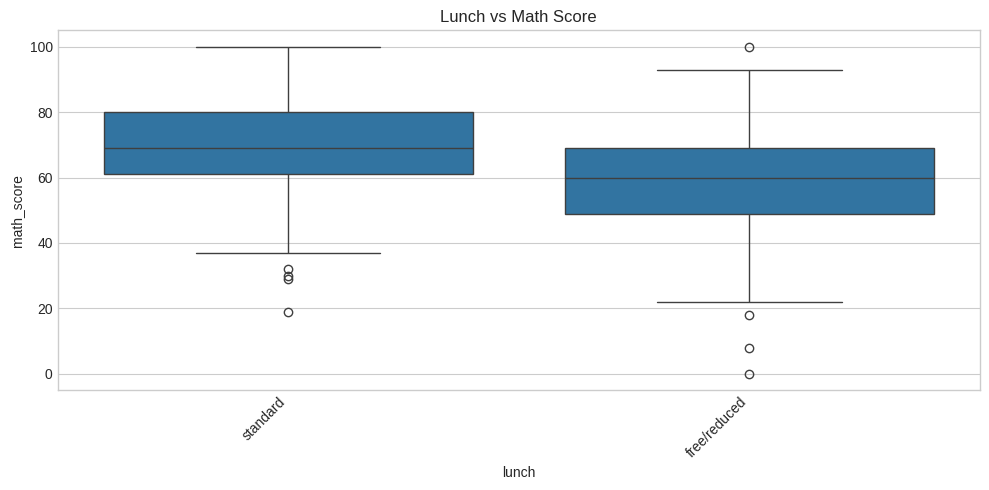

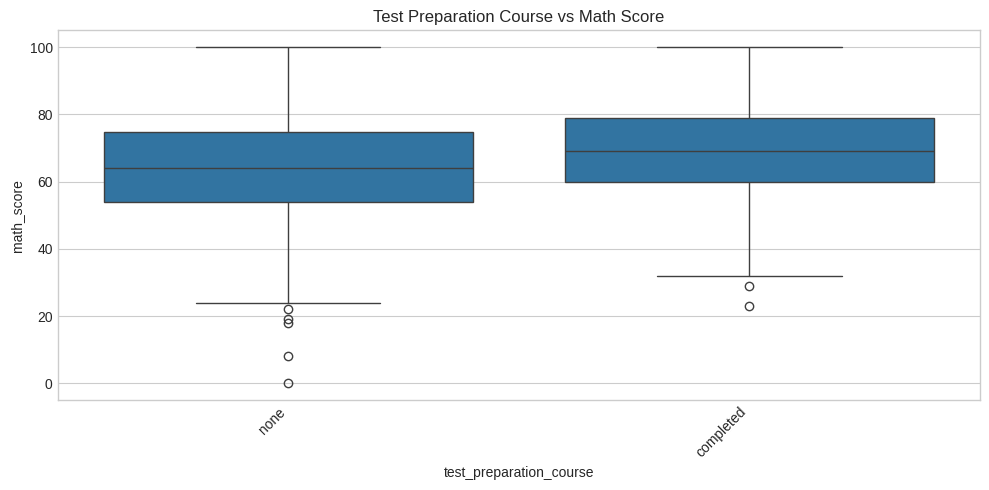

----------------------------------------------------------------------------------------------------


In [ ]:
# Loading the dataset through downloded Kaggle (.csv) file mounted to google drive.

try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
    file_path = '/content/drive/MyDrive/StudentsPerformance.csv'
    print(f"\nAttempting to load dataset from Google Drive: {file_path}")
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully from Google Drive.")

    # Renaming the columns for consistency and ease of use
    df.columns = [col.lower().replace(' ', '_').replace('/', '_') for col in df.columns]
    print("\nDataset columns renamed for consistency:")
    print(df.columns)
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

except FileNotFoundError:
    print(f"\nError: File not found at the specified path in Google Drive: {file_path}")
    print("Please ensure:")
    print("1. You have uploaded 'StudentsPerformance.csv' to the root of your Google Drive ('My Drive').")
    print("2. The file name is exactly 'StudentsPerformance.csv'.")
except Exception as e:
    print(f"An error occurred during Google Drive mount or file loading: {e}")

if df.empty:
    print("\nCritical error: Could not load dataset. Subsequent cells may fail.")
print("-" * 100)

# Defining the target variable
target_variable = 'math_score'
print(f"Target variable: '{target_variable}'")

# Checking for missing values
print("\nMissing values check:")
missing_values = df.isnull().sum() # This will raise an error if df is not a DataFrame (e.g. None) or empty in a way that .isnull() fails
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
else:
    print(f"Found {missing_values.sum()} missing values. Columns with missing values:\n{missing_values[missing_values > 0]}")

# Identifying categorical and numerical columns for features
print("\nIdentifying feature types:")
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Removing the target variable from the list of numerical features
if target_variable in numerical_cols:
    numerical_cols.remove(target_variable)
# Ensuring target is not accidentally in categorical columns if it were object type
if target_variable in categorical_cols:
    categorical_cols.remove(target_variable)

print(f"Identified Categorical columns (features): {categorical_cols}")
print(f"Identified Numerical columns (features): {numerical_cols}")
print("-" * 100)

# Enabling numerical features correlation with the target
print("\nVisualizing correlation of numerical features with the target...")
plt.figure(figsize=(8, 6))
correlation_matrix = df[numerical_cols + [target_variable]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title(f'Correlation Matrix: Numerical Features & {target_variable.replace("_", " ").title()}')
plt.show()
print(f"\nCorrelation of numerical features with '{target_variable}':")
print(correlation_matrix[target_variable].drop(target_variable).sort_values(ascending=False))

# Enabling categorical features relationship with the target (using box plots)
print(f"\nVisualizing relationship between categorical features and '{target_variable}'...")
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[col], y=df[target_variable])
    plt.title(f'{col.replace("_", " ").title()} vs {target_variable.replace("_", " ").title()}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
print("-" * 100)

**Feature Engineering**

In [ ]:
# Defining the features (X) and target (y)
X = df[categorical_cols + numerical_cols] # Relies on df, categorical_cols, numerical_cols from Cell 2
y = df[target_variable]                   # Relies on df, target_variable from Cell 2
print(f"Features (X) selected: {X.columns.tolist()}")
print(f"Target (y) selected: {target_variable}")

# Creating the preprocessor for encoding categorical variables and scaling numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)
print("\nPreprocessor defined (OneHotEncoder for categoricals, StandardScaler for numericals).")
print("Polynomial features will be generated within the Polynomial Regression pipeline.")
print("-" * 100)

Features (X) selected: ['gender', 'race_ethnicity', 'parental_level_of_education', 'lunch', 'test_preparation_course', 'reading_score', 'writing_score']
Target (y) selected: math_score

Preprocessor defined (OneHotEncoder for categoricals, StandardScaler for numericals).
Polynomial features will be generated within the Polynomial Regression pipeline.
----------------------------------------------------------------------------------------------------


**Model Building**

In [ ]:
# Spliting data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Data split into training and testing sets.")
print(f"Training set shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Test set shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

# Multilinear Regression Model
print("\nBuilding Multilinear Regression model...")
mlr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
mlr_pipeline.fit(X_train, y_train)
print("Multilinear Regression model trained.")

# Polynomial Regression Model (degree 2)
print("\nBuilding Polynomial Regression (degree 2) model...")
poly_degree = 2
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
poly_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('poly', poly_features),
    ('regressor', LinearRegression())
])
poly_pipeline.fit(X_train, y_train)
print(f"Polynomial Regression (degree {poly_degree}) model trained.")
print("-" * 100)

Data split into training and testing sets.
Training set shape: X_train: (800, 7), y_train: (800,)
Test set shape: X_test: (200, 7), y_test: (200,)

Building Multilinear Regression model...
Multilinear Regression model trained.

Building Polynomial Regression (degree 2) model...
Polynomial Regression (degree 2) model trained.
----------------------------------------------------------------------------------------------------


**Model Evaluation**


Multilinear Regression Metrics:
  Training Set:   RMSE: 5.323, MAE: 4.267, R²: 0.874
  Test Set:       RMSE: 5.394, MAE: 4.215, R²: 0.880

Polynomial Regression (Degree 2) Metrics:
  Training Set:   RMSE: 5.058, MAE: 4.013, R²: 0.887
  Test Set:       RMSE: 5.727, MAE: 4.544, R²: 0.865

Visualizing Predicted vs Actual values on Test Set...


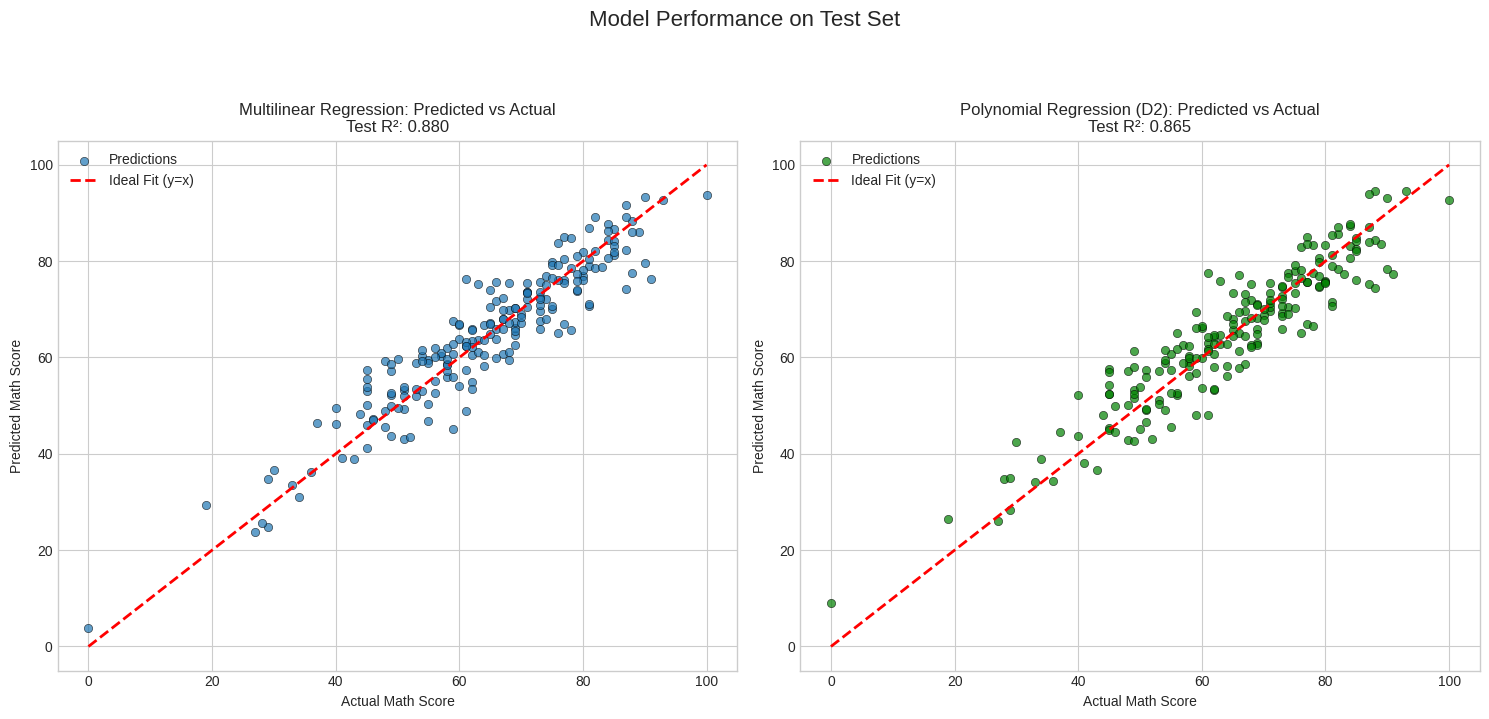


Discussing Overfitting/Underfitting (based on R² scores):

Multilinear Regression Analysis:
  Good Generalization: Training R² (0.874) and Test R² (0.880) are reasonably close, and Test R² is adequate.

Polynomial Regression (Degree 2) Analysis:
  Good Generalization: Training R² (0.887) and Test R² (0.865) are reasonably close, and Test R² is adequate.


Summary of Test Set R² for Comparative Discussion:
- Multilinear Regression Test R²: 0.880
- Polynomial Regression (Degree 2) Test R²: 0.865
(Detailed interpretation and comparison of applied models is provided below in the Text Cell.)

----------------------------------------------------------------------------------------------------


In [ ]:
# Developing a helper function for printing regression metrics
def print_regression_metrics(model_name, y_true_train, y_pred_train, y_true_test, y_pred_test):
    train_rmse = np.sqrt(mean_squared_error(y_true_train, y_pred_train))
    train_mae = mean_absolute_error(y_true_train, y_pred_train)
    train_r2 = r2_score(y_true_train, y_pred_train)
    test_rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    test_mae = mean_absolute_error(y_true_test, y_pred_test)
    test_r2 = r2_score(y_true_test, y_pred_test)
    print(f"\n{model_name} Metrics:")
    print(f"  Training Set:   RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, R²: {train_r2:.3f}")
    print(f"  Test Set:       RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}, R²: {test_r2:.3f}")
    return train_r2, test_r2

# Evaluating Multilinear Regression
y_pred_mlr_train = mlr_pipeline.predict(X_train)
y_pred_mlr_test = mlr_pipeline.predict(X_test)
mlr_train_r2, mlr_test_r2 = print_regression_metrics("Multilinear Regression", y_train, y_pred_mlr_train, y_test, y_pred_mlr_test)

# Evaluating Polynomial Regression (degree 2)
y_pred_poly_train = poly_pipeline.predict(X_train)
y_pred_poly_test = poly_pipeline.predict(X_test)
poly_train_r2, poly_test_r2 = print_regression_metrics(f"Polynomial Regression (Degree {poly_degree})", y_train, y_pred_poly_train, y_test, y_pred_poly_test)

# Visualizing the predicted vs actual (on Test Data)
print("\nVisualizing Predicted vs Actual values on Test Set...")
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred_mlr_test, alpha=0.7, label='Predictions', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit (y=x)')
plt.title(f'Multilinear Regression: Predicted vs Actual\nTest R²: {mlr_test_r2:.3f}')
plt.xlabel(f'Actual {target_variable.replace("_", " ").title()}')
plt.ylabel(f'Predicted {target_variable.replace("_", " ").title()}')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred_poly_test, alpha=0.7, color='green', label='Predictions', edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit (y=x)')
plt.title(f'Polynomial Regression (D{poly_degree}): Predicted vs Actual\nTest R²: {poly_test_r2:.3f}')
plt.xlabel(f'Actual {target_variable.replace("_", " ").title()}')
plt.ylabel(f'Predicted {target_variable.replace("_", " ").title()}')
plt.legend()
plt.grid(True)

plt.suptitle('Model Performance on Test Set', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Checking for overfitting/underfitting
print("\nDiscussing Overfitting/Underfitting (based on R² scores):")

print("\nMultilinear Regression Analysis:")
if abs(mlr_train_r2 - mlr_test_r2) > 0.1 and mlr_train_r2 > mlr_test_r2:
    print(f"  Potential Overfitting: Training R² ({mlr_train_r2:.3f}) is notably higher than Test R² ({mlr_test_r2:.3f}).")
elif mlr_test_r2 < 0.6:
    print(f"  Potential Underfitting: Test R² ({mlr_test_r2:.3f}) is relatively low.")
else:
    print(f"  Good Generalization: Training R² ({mlr_train_r2:.3f}) and Test R² ({mlr_test_r2:.3f}) are reasonably close, and Test R² is adequate.")

print(f"\nPolynomial Regression (Degree {poly_degree}) Analysis:")
if abs(poly_train_r2 - poly_test_r2) > 0.1 and poly_train_r2 > poly_test_r2:
    print(f"  Potential Overfitting: Training R² ({poly_train_r2:.3f}) is notably higher than Test R² ({poly_test_r2:.3f}).")
elif poly_test_r2 < 0.6:
    print(f"  Potential Underfitting: Test R² ({poly_test_r2:.3f}) is relatively low.")
else:
    print(f"  Good Generalization: Training R² ({poly_train_r2:.3f}) and Test R² ({poly_test_r2:.3f}) are reasonably close, and Test R² is adequate.")

print(f"""
\nSummary of Test Set R² for Comparative Discussion:
- Multilinear Regression Test R²: {mlr_test_r2:.3f}
- Polynomial Regression (Degree {poly_degree}) Test R²: {poly_test_r2:.3f}
(Detailed interpretation and comparison of applied models is provided below in the Text Cell.)
""")
print("-" * 100)

### **Final Outcome**: Comparative Discussion of Models

After evaluating both the Multilinear Regression and the Polynomial Regression (Degree 2) models, we can compare their performance on the task of predicting student math scores.

The **Multilinear Regression model** achieved a test R² of 0.880, an RMSE of 5.394, and an MAE of 4.215. This indicates that the model explains approximately 88.0% of the variance in math scores on unseen data, with an average prediction error magnitude (RMSE) of about 5.39 points.

The **Polynomial Regression (Degree 2) model** yielded a test R² of 0.865, an RMSE of 5.727, and an MAE of 4.544. This model explains approximately 86.5% of the variance in math scores on the test set, with an average prediction error magnitude of about 5.73 points.

Comparing these results, the **Multilinear Regression model demonstrated slightly better performance on the test set** across all key metrics. It not only achieved a higher R² score but also lower RMSE and MAE values, suggesting its predictions were, on average, more accurate and closer to the actual student scores than those from the Polynomial Regression model.